## MNIST example

This notebook demonstrates and end-to-end application of the glimr package.

Using MNIST classification as a simple example, we demonstrate the steps to create a search space, model builder, and dataloader for use in tuning. This provides a concrete example of topics like using the `glimr.utils` and `glimr.keras` functions to create hyperparameters and to correctly name losses and metrics for training and reporting.

This is followed by a demonstration of the `Search` class to show how to setup and run experiments.

In [1]:
!pip install ../../glimr

Processing /Users/lcoop22/Desktop/glimr
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


  Created wheel for glimr: filename=glimr-0.1.dev54+g77e1db8.d20230323-py3-none-any.whl size=18684 sha256=773b05a0f2685951d109c9cac98825ddae327b484228991071b4e9b64dc5fb37
  Stored in directory: /private/var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/pip-ephem-wheel-cache-chokxnkt/wheels/58/08/39/c88c61a75aca3782dfcc11b86c8a6af860f75d1d00fddf72e2
Successfully built glimr
  Attempting uninstall: glimr
    Found existing installation: glimr 0.1.dev54+g77e1db8.d20230323
    Uninstalling glimr-0.1.dev54+g77e1db8.d20230323:
      Successfully uninstalled glimr-0.1.dev54+g77e1db8.d20230323


# Creating the search space

First let's create a search space for a simple two layer network for a multiclass MNIST classifier.

This search space will consist of hyperparameters for each layer, for loss, for gradient optimization, and for data loading and preprocessing. Below we build these components incrementally and examine each in detail.

### The first layer

For the first layer we define the possible layer activations, dropout rate, and number of units. Where defining a range hyperparameter, we use `tune.quniform` which creates a quantized floating point hyperparameter. Where choosing among discrete options, we use `tune.choice` which performs a random selection.

In [2]:
# import optimization search space from glimr
from pprint import pprint
from ray import tune

# define the possible layer activations
activations = tune.choice(
    ["elu", "gelu", "linear", "relu", "selu", "sigmoid", "softplus"]
)

# define the layer 1 hyperparameters
layer1 = {
    "activation": activations,
    "dropout": tune.quniform(0.0, 0.2, 0.05),
    "units": tune.choice([64, 48, 32, 16]),
}

### Defining losses and metrics

Since losses can have a significant impact on performance, we may want to treat loss as a hyperparameter. Additionally, losses may have hyperparameters like label smoothting that can impact performance. Here we define a nested dictionary that randomizes choice of a hinge or cross entropy loss, and that defines label smoothing as a hyperparameter for cross entropy. Each loss has a `name` that is decoded by the model builder function to generate a `tf.keras.losses.Loss` object, and an optional `kwargs` dictionary that is used to create this object.

Loss weights are assigned for each loss, and can set as hyperparameters, although here we set the loss weight to 1.

Metrics provide feedback on model performance and are how Ray Tune ranks models, so they are not hyperparameters.

In [3]:
# set the loss as a hyperparameter
loss = tune.choice(
    [
        {"name": "categorical_hinge"},
        {
            "name": "categorical_crossentropy",
            "kwargs": {"label_smoothing": tune.quniform(0.0, 0.2, 0.01)},
        },
    ]
)

# use a fixed loss weight
loss_weight = (1.0,)

# set fixed metrics for reporting to Ray Tune
metrics = {
    "auc": {
        "name": "auc",
        "kwargs": {"from_logits": True},
    }
}

### Define the second layer / task

We refer to the terminal outputs / layers of a network as _tasks_. Each task is named to allow automatic linking of metrics and losses at compilation time for multi-task networks, and to simplify the naming and selection of the metric used by Ray to identify the best model/trial.

The specific formulation of a task depends on the model builder function, but here we define a task as a layer that has additional loss, loss weight, and metric values.

In [4]:
# define the task
task = {
    "activation": activations,
    "dropout": tune.quniform(0.0, 0.2, 0.05),
    "units": 10,
    "loss": loss,
    "loss_weight": loss_weight,
    "metrics": metrics,
}

### Optimization hyperparameters

Optimization hyperparameters include the maximum number of epochs for a trial, the gradient descent algorithm, and the algorithm hyperparameters like learning rate or momentum.

Glimr defines an optimization search space and an optimization builder in `glimr.keras.keras_optimizer`.

In [5]:
from glimr.optimization import optimization_space

optimization = optimization_space()

2023-03-23 10:35:16.060257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data loader hyperparameters

Data loader hyperparameters include a required `batch_size` hyperparameter, as well as user-defined hyperparameters to control loading and preprocessing behavior. Here we define a variable batch size, and randomize the application of a brightness transform.

In [6]:
# data loader keyword arguments to control loading, augmentation, and batching
data = {
    "batch_size": tune.choice([32, 64, 128]),
    "random_brightness": tune.choice(
        [True, False]
    ),  # whether to perform random brightness transformation
    "max_delta": tune.quniform(0.01, 0.15, 0.01),
}

### Putting it all together

The keys `data`, `optimization`, and `tasks` are all required keys that `glimr.search.Search` uses to build models during trials. For `tasks`, a dictionary maps the user-designated task names to the task dictionaries like the one defined above. A multi-task model will contain multiple task key/value pairs.

In [7]:
# put it all together
space = {
    "layer1": layer1,
    "optimization": optimization_space(),
    "tasks": {"mnist": task},
    "data": data,
}

# display search space
pprint(space, indent=4)

{   'data': {   'batch_size': <ray.tune.search.sample.Categorical object at 0x7ff46c7ab7c0>,
                'max_delta': <ray.tune.search.sample.Float object at 0x7ff46c7ab7f0>,
                'random_brightness': <ray.tune.search.sample.Categorical object at 0x7ff46c7ab040>},
    'layer1': {   'activation': <ray.tune.search.sample.Categorical object at 0x7ff481e9e3a0>,
                  'dropout': <ray.tune.search.sample.Float object at 0x7ff481e9e2b0>,
                  'units': <ray.tune.search.sample.Categorical object at 0x7ff484ba86d0>},
    'optimization': {   'batch': <ray.tune.search.sample.Categorical object at 0x7ff484bbb6d0>,
                        'beta_1': <ray.tune.search.sample.Float object at 0x7ff46b5bc9a0>,
                        'beta_2': <ray.tune.search.sample.Float object at 0x7ff46c6f5970>,
                        'epochs': 100,
                        'learning_rate': <ray.tune.search.sample.Float object at 0x7ff46b5a9fd0>,
                        'method':

### Sample a config from the search space and display

In [8]:
from glimr.utils import sample_space

config = sample_space(space)
pprint(config, indent=4)

{   'data': {'batch_size': 32, 'max_delta': 0.07, 'random_brightness': False},
    'layer1': {'activation': 'linear', 'dropout': 0.05, 'units': 64},
    'optimization': {   'batch': 128,
                        'beta_1': 0.61,
                        'beta_2': 0.91,
                        'epochs': 100,
                        'learning_rate': 0.00877,
                        'method': 'sgd',
                        'momentum': 0.03,
                        'rho': 0.85},
    'tasks': {   'mnist': {   'activation': 'softplus',
                              'dropout': 0.05,
                              'loss': {   'kwargs': {'label_smoothing': 0.08},
                                          'name': 'categorical_crossentropy'},
                              'loss_weight': (1.0,),
                              'metrics': {   'auc': {   'kwargs': {   'from_logits': True},
                                                        'name': 'auc'}},
                              'units': 10}}}

# Implement the model-building function

The model-builder function transforms a sample of the space into a `tf.keras.Model`, and loss, loss weight, and metric inputs for model compilation. This is a user-defined function to provide maximum flexibility in the models that can be used with glimr.

In [9]:
from glimr.keras import keras_losses, keras_metrics
import tensorflow as tf


def builder(config):
    # a helper function for building layers
    def _build_layer(x, units, activation, dropout, name):
        # dense layer
        x = tf.keras.layers.Dense(units, activation=activation, name=name)(x)

        # add dropout if necessary
        if dropout > 0.0:
            x = tf.keras.layers.Dropout(dropout)(x)

        return x

    # create input layer
    input_layer = tf.keras.Input([784], name="input")

    # build layer 1
    x = _build_layer(
        input_layer,
        config["layer1"]["units"],
        config["layer1"]["activation"],
        config["layer1"]["dropout"],
        "layer1",
    )

    # build output / task layer
    task_name = list(config["tasks"].keys())[0]
    output = _build_layer(
        input_layer,
        config["tasks"][task_name]["units"],
        config["tasks"][task_name]["activation"],
        config["tasks"][task_name]["dropout"],
        task_name,
    )

    # build named output dict
    named = {f"{task_name}": output}

    # create model
    model = tf.keras.Model(inputs=input_layer, outputs=named)

    # create a loss dictionary using utility function
    loss_mapper = {
        "categorical_crossentropy": tf.keras.losses.CategoricalCrossentropy,
        "categorical_hinge": tf.keras.losses.CategoricalHinge,
    }
    losses, loss_weights = keras_losses(config, loss_mapper)

    # create a metric dictionary using utility function
    metric_mapper = {"auc": tf.keras.metrics.AUC}
    metrics = keras_metrics(config, metric_mapper)

    return model, losses, loss_weights, metrics

# Create a data loading function

Write a function to load and batch mnist samples. Flatten the images and apply a one-hot encoding to the labels.

In [10]:
import numpy as np


def dataloader(batch_size, random_brightness, max_delta):
    # load mnist data
    train, validation = tf.keras.datasets.mnist.load_data(path="mnist.npz")

    # flattening function
    def mnist_flat(features):
        return features.reshape(
            features.shape[0], features.shape[1] * features.shape[2]
        )

    # extract features, labels
    train_features = tf.cast(mnist_flat(train[0]), tf.float32) / 255.0
    train_labels = train[1]
    validation_features = tf.cast(mnist_flat(validation[0]), tf.float32) / 255.0
    validation_labels = validation[1]

    # build datasets
    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_features, {"mnist": tf.one_hot(train_labels, 10)})
    )
    validation_ds = tf.data.Dataset.from_tensor_slices(
        (validation_features, {"mnist": tf.one_hot(validation_labels, 10)})
    )

    # batch
    train_ds = train_ds.shuffle(len(train_labels), reshuffle_each_iteration=True)
    train_ds = train_ds.batch(batch_size)
    validation_ds = validation_ds.batch(batch_size)

    # apply augmentation
    if random_brightness:
        train_ds = train_ds.map(
            lambda x, y: (tf.image.random_brightness(x, max_delta), y)
        )

    return train_ds, validation_ds

### Test the search space, model builder, and dataloader

Before doing a hyperparameter search, let's test this combination to verify that the models can train.

We generate a sample configuration from the search space and build, compile, and train a model with this config.

In [11]:
from glimr.keras import keras_optimizer
import ray

# sample a configuration
config = sample_space(space)

# display the configuration
from pprint import pprint

pprint(config, indent=4)

# build the model
model, losses, loss_weights, metrics = builder(config)

# build the optimizer
optimizer = keras_optimizer(config["optimization"])

# test compile the model
model.compile(
    optimizer=optimizer, loss=losses, metrics=metrics, loss_weights=loss_weights
)

# build dataset and train
train_ds, val_ds = dataloader(**config["data"])
model.fit(x=train_ds, validation_data=val_ds, epochs=10)

{   'data': {'batch_size': 32, 'max_delta': 0.11, 'random_brightness': True},
    'layer1': {'activation': 'linear', 'dropout': 0.1, 'units': 64},
    'optimization': {   'batch': 64,
                        'beta_1': 0.66,
                        'beta_2': 0.8300000000000001,
                        'epochs': 100,
                        'learning_rate': 0.0012300000000000002,
                        'method': 'adam',
                        'momentum': 0.0,
                        'rho': 0.74},
    'tasks': {   'mnist': {   'activation': 'gelu',
                              'dropout': 0.1,
                              'loss': {'name': 'categorical_hinge'},
                              'loss_weight': (1.0,),
                              'metrics': {   'auc': {   'kwargs': {   'from_logits': True},
                                                        'name': 'auc'}},
                              'units': 10}}}


2023-03-23 10:35:21.432284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3746 - auc: 0.9297 - val_loss: 0.2157 - val_auc: 0.9593
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3025 - auc: 0.9276 - val_loss: 0.1899 - val_auc: 0.9574
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2914 - auc: 0.9262 - val_loss: 0.1919 - val_auc: 0.9529
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2858 - auc: 0.9237 - val_loss: 0.1865 - val_auc: 0.9551
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2822 - auc: 0.9220 - val_loss: 0.1797 - val_auc: 0.9530
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2791 - auc: 0.9215 - val_loss: 0.1750 - val_auc: 0.

# Using Search for hyperparameter tuning

The `Search` class implements the hyperparameter tuning process of Ray Tune. It provides sensible defaults for the many options available in Ray Tune, but also allows fine grained access to these options through class methods and attributes. Options can be added or assigned incrementally to alter reporting, checkpointing, trial stopping criteria, and resources used in experiments.

We begin with a basic experiment using the AsyncHyperBandScheduler which performs a random search but terminates poorly performing trials early.

By default if a reporter is not set, however, Ray Tune will display a dynamic table of ongoing experiments and results if running in Jupyter.

In [12]:
import contextlib
from glimr.search import Search
import os
import tempfile

# Initialize a Search instance with the search space, model builder, and
# data loader. The name of the metric and indicate to Ray how to measure
# model performance, and are provided in format task_metric. This is the
# convention when building models using glimr.keras.keras_metrics.
tuner = Search(space, builder, dataloader, "mnist_auc")

# make a temporary directory to store outputs - cleanup at end
temp_dir = tempfile.TemporaryDirectory()

# run trials using default settings
with contextlib.redirect_stderr(open(os.devnull, "w")):
    results = tuner.experiment(local_dir=temp_dir.name, name="default", num_samples=20)

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mnist_auc,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_66c94_00000,2023-03-23_10-36-44,True,,11d4d42b432944b39166f36e0ddc060d,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.984643,127.0.0.1,26754,True,39.9357,5.15874,39.9357,1679585804,0,,4,66c94_00000,0.0144451
trainable_66c94_00001,2023-03-23_10-37-09,True,,cf4e86556efc40f9b4388ce81f2ea231,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,20,0.878336,127.0.0.1,26766,True,55.9765,2.29567,55.9765,1679585829,0,,20,66c94_00001,0.0128641
trainable_66c94_00002,2023-03-23_10-36-38,True,,83776f0b837e41f7b0c2ef7a32c8d104,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.508563,127.0.0.1,26771,True,17.5793,3.06923,17.5793,1679585798,0,,4,66c94_00002,0.012542
trainable_66c94_00003,2023-03-23_10-36-39,True,,681852bcf835410981b504ea0eb0f59a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.96666,127.0.0.1,26780,True,9.99596,2.21071,9.99596,1679585799,0,,4,66c94_00003,0.013834
trainable_66c94_00004,2023-03-23_10-37-32,True,,83776f0b837e41f7b0c2ef7a32c8d104,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,10,0.823206,127.0.0.1,26771,True,53.4724,5.62711,53.4724,1679585852,0,,10,66c94_00004,0.012542
trainable_66c94_00005,2023-03-23_10-37-05,True,,681852bcf835410981b504ea0eb0f59a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,11,0.930072,127.0.0.1,26780,True,25.0395,2.72472,25.0395,1679585825,0,,11,66c94_00005,0.013834
trainable_66c94_00006,2023-03-23_10-37-29,True,,11d4d42b432944b39166f36e0ddc060d,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,13,0.911196,127.0.0.1,26754,True,44.8636,3.20338,44.8636,1679585849,0,,13,66c94_00006,0.0144451
trainable_66c94_00007,2023-03-23_10-37-30,True,,681852bcf835410981b504ea0eb0f59a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0,127.0.0.1,26780,True,24.9283,5.28295,24.9283,1679585850,0,,4,66c94_00007,0.013834
trainable_66c94_00008,2023-03-23_10-37-33,True,,cf4e86556efc40f9b4388ce81f2ea231,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,10,0.686192,127.0.0.1,26766,True,23.7824,1.88375,23.7824,1679585853,0,,10,66c94_00008,0.0128641
trainable_66c94_00009,2023-03-23_10-37-54,True,,11d4d42b432944b39166f36e0ddc060d,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.976655,127.0.0.1,26754,True,24.0394,5.6313,24.0394,1679585874,0,,4,66c94_00009,0.0144451


### Display information about the best trial

The output from `Search.experiment` contains information on each trial's performance and configuration, and can be used for trial analysis and for keeping the best checkpointed result.

In [13]:
# get information about the best trial
best_result = results.get_best_result()
best_auc = best_result.metrics["mnist_auc"]
best_config = best_result.metrics["config"]
best_checkpoint = best_result.checkpoint.to_directory()

# display
print(f"best result auc: {best_auc}")
print("best configuration:")
pprint(best_config, indent=4)
print("contents of best trial checkpoint:")
print(os.listdir(os.path.join(best_checkpoint, "checkpoint")))

best result auc: 0.9854261875152588
best configuration:
{   'builder': <function builder at 0x7ff46079ed30>,
    'data': {'batch_size': 32, 'max_delta': 0.1, 'random_brightness': True},
    'fit_kwargs': {},
    'layer1': {   'activation': 'relu',
                  'dropout': 0.15000000000000002,
                  'units': 16},
    'loader': <function dataloader at 0x7ff4601e64c0>,
    'optimization': {   'batch': 128,
                        'beta_1': 0.6900000000000001,
                        'beta_2': 0.75,
                        'epochs': 100,
                        'learning_rate': 0.0099,
                        'method': 'sgd',
                        'momentum': 0.06,
                        'rho': 0.87},
    'tasks': {   'mnist': {   'activation': 'selu',
                              'dropout': 0.2,
                              'loss': {'name': 'categorical_hinge'},
                              'loss_weight': (1.0,),
                              'metrics': {   'auc': { 

### Experiment performance statistics for default settings

Let's plot the performance of trials from the default experiment which uses an AsyncHyperband scheduler with a random search.

Text(0, 0.5, 'AUC')

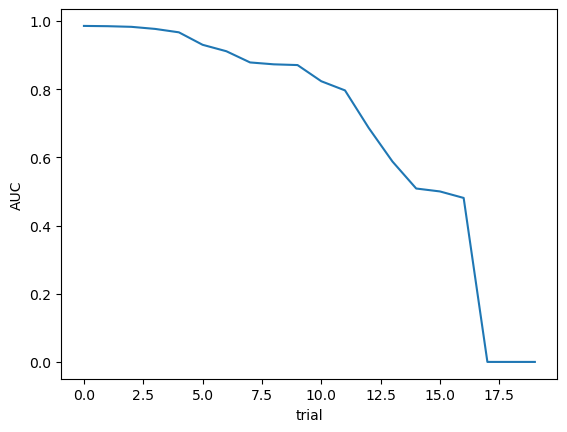

In [14]:
# get dataframe from default experiment
default_table = results.get_dataframe()
default_auc = np.array(default_table["mnist_auc"])

# plot
import matplotlib.pyplot as plt

plt.plot(-np.sort(-default_auc))
plt.xlabel("trial")
plt.ylabel("AUC")

### Using a population-based training scheduler

Let's change the scheduler to population-based training (PBT). PBT optimizes resource utililzation by replacing poorly performing trials with "mutated" versions of top performing trials.

We recommend creating a new `Search` object for every experiment to avoid issues with Ray Tune.

In [15]:
from ray.tune.schedulers import PopulationBasedTraining

# create a Search object instance
tuner = Search(space, builder, dataloader, "mnist_auc")

# create the PBT trainer - the entire search space eligible for mutation
scheduler = PopulationBasedTraining(
    time_attr="training_iteration", hyperparam_mutations=space
)

# run trials with the PBT trainer
with contextlib.redirect_stderr(open(os.devnull, "w")):
    results = tuner.experiment(
        local_dir=temp_dir.name, name="pbt", num_samples=20, scheduler=scheduler
    )

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mnist_auc,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_cd789_00000,2023-03-23_10-39-26,True,,9646c5c1efbe4bd997dcfbc2fbebf85a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.93192,127.0.0.1,26944,True,30.4042,2.57097,30.4042,1679585966,0,,5,cd789_00000,0.0113721
trainable_cd789_00001,2023-03-23_10-39-26,True,,239508fcee0748789df6481f22110afb,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.942595,127.0.0.1,26953,True,23.6703,2.54285,23.6703,1679585966,0,,5,cd789_00001,0.0113108
trainable_cd789_00002,2023-03-23_10-39-21,True,,c8d7917d8127407297640151a14c41f8,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.984686,127.0.0.1,26958,True,12.5206,1.66475,12.5206,1679585961,0,,4,cd789_00002,0.0119579
trainable_cd789_00003,2023-03-23_10-39-36,True,,39608c7ea523454bb30253cd98f48ed2,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.432352,127.0.0.1,26965,True,20.162,4.66465,20.162,1679585976,0,,4,cd789_00003,0.0133462
trainable_cd789_00004,2023-03-23_10-39-29,True,,c8d7917d8127407297640151a14c41f8,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.962755,127.0.0.1,26958,True,7.97447,1.71138,7.97447,1679585969,0,,4,cd789_00004,0.0119579
trainable_cd789_00005,2023-03-23_10-39-46,True,,239508fcee0748789df6481f22110afb,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.983597,127.0.0.1,26953,True,19.6137,4.62401,19.6137,1679585986,0,,4,cd789_00005,0.0113108
trainable_cd789_00006,2023-03-23_10-39-37,True,,9646c5c1efbe4bd997dcfbc2fbebf85a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.953877,127.0.0.1,26944,True,10.5745,1.71591,10.5745,1679585977,0,,5,cd789_00006,0.0113721
trainable_cd789_00007,2023-03-23_10-39-43,True,,c8d7917d8127407297640151a14c41f8,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,6,0.520409,127.0.0.1,26958,True,13.6075,2.51067,13.6075,1679585983,0,,6,cd789_00007,0.0119579
trainable_cd789_00008,2023-03-23_10-39-50,True,,39608c7ea523454bb30253cd98f48ed2,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.467968,127.0.0.1,26965,True,13.6587,3.03011,13.6587,1679585990,0,,4,cd789_00008,0.0133462
trainable_cd789_00009,2023-03-23_10-39-51,True,,9646c5c1efbe4bd997dcfbc2fbebf85a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.918962,127.0.0.1,26944,True,13.4169,2.83003,13.4169,1679585991,0,,4,cd789_00009,0.0113721


### Compare PBT and default experiment performance statistics

Plot the PBT trial performance alongside the default AsyncHyperband results.

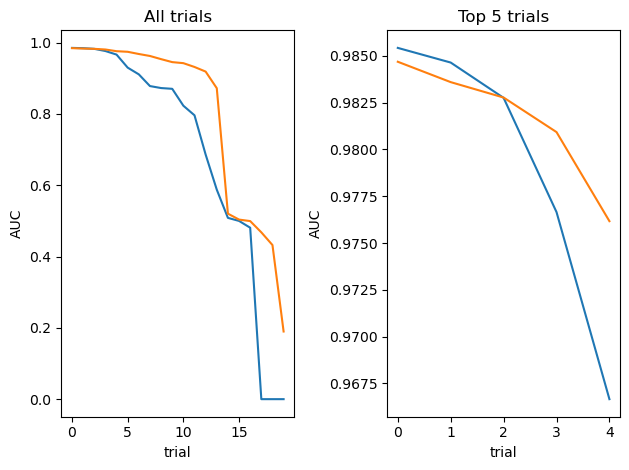

In [16]:
# get dataframe from default experiment
pbt_table = results.get_dataframe()
pbt_auc = np.array(pbt_table["mnist_auc"])

# plot
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(-np.sort(-default_auc))
ax1.plot(-np.sort(-pbt_auc))
ax1.set_title("All trials")
ax1.set_xlabel("trial")
ax1.set_ylabel("AUC")
ax2.plot(-np.sort(-default_auc)[0:5])
ax2.plot(-np.sort(-pbt_auc)[0:5])
ax2.set_title("Top 5 trials")
ax2.set_xlabel("trial")
ax2.set_ylabel("AUC")
f.tight_layout()

### Change trial resources

The `ray.air.ScalingConfig` determines the resources available during experiments, and can be used to set the number of workers and availability of GPUs. Additional parameters are available for running on multiple machine using a Ray cluster.

In [17]:
# create a Search object instance
tuner = Search(space, builder, dataloader, "mnist_auc")

# alter the scaling parameters so that each trial gets 2 cores
tuner.set_scaling(
    num_workers=1,
    use_gpu=False,
    resources_per_worker={"CPU": 2, "GPU": 0},
)

# run 10 trials with the PBT trainer
with contextlib.redirect_stderr(open(os.devnull, "w")):
    results = tuner.experiment(
        local_dir=temp_dir.name, name="resources", num_samples=10
    )

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mnist_auc,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_1a898_00000,2023-03-23_10-41-17,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.561562,127.0.0.1,27057,True,12.127,1.28693,12.127,1679586077,0,,4,1a898_00000,0.0109162
trainable_1a898_00001,2023-03-23_10-42-42,True,,971169efca2a4e9e9cf9664fe3b10592,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,26,0.784365,127.0.0.1,27066,True,88.8325,3.37576,88.8325,1679586162,0,,26,1a898_00001,0.0111148
trainable_1a898_00002,2023-03-23_10-41-24,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.960655,127.0.0.1,27057,True,6.82926,1.41669,6.82926,1679586084,0,,4,1a898_00002,0.0109162
trainable_1a898_00003,2023-03-23_10-41-50,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,7,0.965961,127.0.0.1,27057,True,25.6813,3.39779,25.6813,1679586110,0,,7,1a898_00003,0.0109162
trainable_1a898_00004,2023-03-23_10-41-59,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.922071,127.0.0.1,27057,True,9.01733,1.93253,9.01733,1679586119,0,,4,1a898_00004,0.0109162
trainable_1a898_00005,2023-03-23_10-42-14,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.86968,127.0.0.1,27057,True,14.6589,2.9786,14.6589,1679586134,0,,4,1a898_00005,0.0109162
trainable_1a898_00006,2023-03-23_10-42-23,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0,127.0.0.1,27057,True,9.09656,1.94306,9.09656,1679586143,0,,4,1a898_00006,0.0109162
trainable_1a898_00007,2023-03-23_10-42-32,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.48098,127.0.0.1,27057,True,9.20597,2.0025,9.20597,1679586152,0,,4,1a898_00007,0.0109162
trainable_1a898_00008,2023-03-23_10-42-47,True,,4b6ec780b924441dbcef073994a005de,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.948291,127.0.0.1,27057,True,14.5817,3.02497,14.5817,1679586167,0,,4,1a898_00008,0.0109162
trainable_1a898_00009,2023-03-23_10-43-01,True,,971169efca2a4e9e9cf9664fe3b10592,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,10,0.927516,127.0.0.1,27066,True,19.452,1.77454,19.452,1679586181,0,,10,1a898_00009,0.0111148


### Reporting

Reporting options can also be set by using `Search.set_reporter` method or by creating a reporter object and assigning this directly to the `Search.reporter` attribute. This allows use of additional parameters not exposed by `set_reporter`.

Here we setup a CLI trainer with customized report columns and re-run an experiment. Since we are running in Jupyter, the dynamic table is also automatically displayed too.

In [18]:
from ray.tune import CLIReporter

# report every 30 seconds
max_report_frequency = 30

# set Jupyter preference
jupyter = False

# set metrics, parameters to display
metrics = [f"{t}_{m}" for t in space["tasks"] for m in space["tasks"][t]["metrics"]]
parameters = {
    "optimization/method": "method",
    "optimization/learning_rate": "learning rate",
    "layer1/units": "layer1_units",
}

# set reporter kwargs
reporter_kwargs = {
    "metric_columns": metrics,
    "parameter_columns": parameters,
    "max_report_frequency": max_report_frequency,
}

# create a Search object instance
tuner = Search(space, builder, dataloader, "mnist_auc")

# assign reporter to attribute and run a short trial
tuner.reporter = CLIReporter(**reporter_kwargs)
with contextlib.redirect_stderr(open(os.devnull, "w")):
    results = tuner.experiment(local_dir=temp_dir.name, name="try", num_samples=10)

== Status ==
Current time: 2023-03-23 10:43:02 (running for 00:00:00.16)
Memory usage on this node: 11.8/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/try
Number of trials: 8/10 (7 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+----------+-----------------+----------------+
| Trial name            | status   | loc             | method   |   learning rate |   layer1_units |
|-----------------------+----------+-----------------+----------+-----------------+----------------|
| trainable_64ed0_00000 | RUNNING  | 127.0.0.1:27171 | adadelta |         0.00467 |             16 |
| trainable_64ed0_00001 | PENDING  |                 | sgd      |         0.00048 |             48 |
| trainable_64ed0_00002 | PENDING  |                 | sgd      |         0.00127 |     

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mnist_auc,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_64ed0_00000,2023-03-23_10-43-46,True,,2a910a812fa64becae50d6421b5250be,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,8,0.920356,127.0.0.1,27171,True,37.6748,5.23207,37.6748,1679586226,0,,8,64ed0_00000,0.011163
trainable_64ed0_00001,2023-03-23_10-43-26,True,,caaa269191444ce1a0caf4af616f11e2,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0,127.0.0.1,27177,True,10.1525,1.94943,10.1525,1679586206,0,,4,64ed0_00001,0.0134208
trainable_64ed0_00002,2023-03-23_10-43-34,True,,00e40df9af6a4f5cb909f01352b3d950,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,8,0.936148,127.0.0.1,27178,True,18.2775,1.9074,18.2775,1679586214,0,,8,64ed0_00002,0.0130932
trainable_64ed0_00003,2023-03-23_10-43-41,True,,e6ac5a8bf91241e98a009d2585e0fda8,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.6359,127.0.0.1,27179,True,25.0866,4.6103,25.0866,1679586221,0,,5,64ed0_00003,0.0132341
trainable_64ed0_00004,2023-03-23_10-43-47,True,,caaa269191444ce1a0caf4af616f11e2,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.956902,127.0.0.1,27177,True,20.4676,5.12946,20.4676,1679586227,0,,4,64ed0_00004,0.0134208
trainable_64ed0_00005,2023-03-23_10-44-06,True,,00e40df9af6a4f5cb909f01352b3d950,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,6,0.942257,127.0.0.1,27178,True,32.2541,4.62432,32.2541,1679586246,0,,6,64ed0_00005,0.0130932
trainable_64ed0_00006,2023-03-23_10-44-04,True,,e6ac5a8bf91241e98a009d2585e0fda8,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0,127.0.0.1,27179,True,23.0457,5.1499,23.0457,1679586244,0,,4,64ed0_00006,0.0132341
trainable_64ed0_00007,2023-03-23_10-44-23,True,,2a910a812fa64becae50d6421b5250be,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,9,0.941618,127.0.0.1,27171,True,36.7284,2.76224,36.7284,1679586263,0,,9,64ed0_00007,0.011163
trainable_64ed0_00008,2023-03-23_10-44-01,True,,caaa269191444ce1a0caf4af616f11e2,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,6,0.966794,127.0.0.1,27177,True,14.7159,1.92271,14.7159,1679586241,0,,6,64ed0_00008,0.0134208
trainable_64ed0_00009,2023-03-23_10-44-13,True,,caaa269191444ce1a0caf4af616f11e2,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0,127.0.0.1,27177,True,10.9755,2.27391,10.9755,1679586253,0,,4,64ed0_00009,0.0134208


== Status ==
Current time: 2023-03-23 10:43:32 (running for 00:00:30.38)
Memory usage on this node: 12.3/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Current best trial: 64ed0_00002 with mnist_auc=0.9238357543945312 and parameters={'optimization/method': 'sgd', 'optimization/learning_rate': 0.00127, 'layer1/units': 32}
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/try
Number of trials: 9/10 (4 PENDING, 4 RUNNING, 1 TERMINATED)
+-----------------------+------------+-----------------+----------+-----------------+----------------+-------------+
| Trial name            | status     | loc             | method   |   learning rate |   layer1_units |   mnist_auc |
|-----------------------+------------+-----------------+----------+-----------------+----------------+-------------|
| trainable_64ed0_00000 | RUNNING    | 127.0.0.1:27171 | 

### Restarting an interrupted experiment

We can restart an experiment that has been interrupted to complete unfinished trials using `Search.restore`.

Interrupt the execution of this cell and then execute the cell below to complete the unexecuted trials.

In [19]:
# create a Search object instance
tuner = Search(space, builder, dataloader, "mnist_auc")

# assign reporter to attribute and run a short trial
tuner.reporter = CLIReporter(**reporter_kwargs)
with contextlib.redirect_stderr(open(os.devnull, "w")):
    results = tuner.experiment(local_dir=temp_dir.name, name="restore", num_samples=50)

== Status ==
Current time: 2023-03-23 10:44:23 (running for 00:00:00.18)
Memory usage on this node: 11.2/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/restore
Number of trials: 8/50 (7 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+----------+-----------------+----------------+
| Trial name            | status   | loc             | method   |   learning rate |   layer1_units |
|-----------------------+----------+-----------------+----------+-----------------+----------------|
| trainable_9565b_00000 | RUNNING  | 127.0.0.1:27247 | adagrad  |         0.00292 |             48 |
| trainable_9565b_00001 | PENDING  |                 | adam     |         0.00224 |             48 |
| trainable_9565b_00002 | PENDING  |                 | adam     |         0.0068  | 

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mnist_auc,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_9565b_00000,2023-03-23_10-44-46,True,,c89f27398b4c42de85e1e6e22caeaaf1,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.711562,127.0.0.1,27247,True,14.8455,2.78664,14.8455,1679586286,0,,5,9565b_00000,0.0112422
trainable_9565b_00001,2023-03-23_10-44-59,True,,bb92a876c994490da6fc3d8d32b9312f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.536975,127.0.0.1,27256,True,19.3459,5.23653,19.3459,1679586299,0,,5,9565b_00001,0.0136571
trainable_9565b_00002,2023-03-23_10-44-53,True,,b9855aab111d422fa9628a0ef9e91d6f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.983355,127.0.0.1,27257,True,13.9578,2.75217,13.9578,1679586293,0,,4,9565b_00002,0.0128491
trainable_9565b_00003,2023-03-23_10-45-04,False,,5e7efa79ceff4ef0991a5397191846ff,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.438053,127.0.0.1,27258,True,24.29,4.35993,24.29,1679586304,0,,5,9565b_00003,0.0131173
trainable_9565b_00004,2023-03-23_10-45-05,True,,c89f27398b4c42de85e1e6e22caeaaf1,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.959825,127.0.0.1,27247,True,18.3549,4.47478,18.3549,1679586305,0,,4,9565b_00004,0.0112422
trainable_9565b_00005,2023-03-23_10-45-05,True,,b9855aab111d422fa9628a0ef9e91d6f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.459297,127.0.0.1,27257,True,11.8885,2.65796,11.8885,1679586305,0,,4,9565b_00005,0.0128491
trainable_9565b_00006,2023-03-23_10-45-10,False,,bb92a876c994490da6fc3d8d32b9312f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,2,0.538627,127.0.0.1,27256,True,11.207,5.07796,11.207,1679586310,0,,2,9565b_00006,0.0136571
trainable_9565b_00007,2023-03-23_10-45-10,False,,c89f27398b4c42de85e1e6e22caeaaf1,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,1,0.524678,127.0.0.1,27247,True,4.73623,4.73623,4.73623,1679586310,0,,1,9565b_00007,0.0112422
trainable_9565b_00008,2023-03-23_10-45-12,False,,b9855aab111d422fa9628a0ef9e91d6f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,1,0.981844,127.0.0.1,27257,True,6.92894,6.92894,6.92894,1679586312,0,,1,9565b_00008,0.0128491


== Status ==
Current time: 2023-03-23 10:44:53 (running for 00:00:30.61)
Memory usage on this node: 12.2/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Current best trial: 9565b_00002 with mnist_auc=0.9833546876907349 and parameters={'optimization/method': 'adam', 'optimization/learning_rate': 0.0068000000000000005, 'layer1/units': 16}
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/restore
Number of trials: 9/50 (4 PENDING, 4 RUNNING, 1 TERMINATED)
+-----------------------+------------+-----------------+----------+-----------------+----------------+-------------+
| Trial name            | status     | loc             | method   |   learning rate |   layer1_units |   mnist_auc |
|-----------------------+------------+-----------------+----------+-----------------+----------------+-------------|
| trainable_9565b_00001 | RUNNING    |

In [20]:
# complete trials
with contextlib.redirect_stderr(open(os.devnull, "w")):
    tuner.restore(local_dir=temp_dir.name + "/restore")

== Status ==
Current time: 2023-03-23 10:45:13 (running for 00:00:00.35)
Memory usage on this node: 12.3/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 2.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Current best trial: 9565b_00002 with mnist_auc=0.9833546876907349 and parameters={'optimization/method': 'adam', 'optimization/learning_rate': 0.0068000000000000005, 'layer1/units': 16}
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/restore
Number of trials: 13/50 (7 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------+------------+-----------------+----------+-----------------+----------------+-------------+
| Trial name            | status     | loc             | method   |   learning rate |   layer1_units |   mnist_auc |
|-----------------------+------------+-----------------+----------+-----------------+----------------+-------------|
| trainable_9565b_00008 | RUNNING    

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mnist_auc,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_9565b_00003,2023-03-23_10-45-58,True,,5e7efa79ceff4ef0991a5397191846ff,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,7,0.558737,127.0.0.1,27296,True,35.2252,4.47991,64.3076,1679586358,0,,13,9565b_00003,0.0285378
trainable_9565b_00006,2023-03-23_10-45-34,True,,bb92a876c994490da6fc3d8d32b9312f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,2,0.540326,127.0.0.1,27294,True,11.8667,5.17338,23.0738,1679586334,0,,4,9565b_00006,0.027601
trainable_9565b_00007,2023-03-23_10-45-38,True,,c89f27398b4c42de85e1e6e22caeaaf1,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,5,0.477976,127.0.0.1,27295,True,16.0057,2.62926,20.7419,1679586338,0,,6,9565b_00007,0.0293958
trainable_9565b_00008,2023-03-23_10-45-39,True,,94003d9e1bb145f9bdfdbd7a2c1dee1a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,3,0.97863,127.0.0.1,27293,True,16.1849,4.46688,16.1849,1679586339,0,,3,9565b_00008,0.0140262
trainable_9565b_00009,2023-03-23_10-45-56,True,,bb92a876c994490da6fc3d8d32b9312f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0,127.0.0.1,27294,True,21.8032,4.97927,21.8032,1679586356,0,,4,9565b_00009,0.027601
trainable_9565b_00010,2023-03-23_10-45-55,True,,c89f27398b4c42de85e1e6e22caeaaf1,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.98374,127.0.0.1,27295,True,16.0635,3.4151,16.0635,1679586355,0,,4,9565b_00010,0.0293958
trainable_9565b_00011,2023-03-23_10-46-10,True,,94003d9e1bb145f9bdfdbd7a2c1dee1a,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,14,0.88723,127.0.0.1,27293,True,31.0799,2.08615,31.0799,1679586370,0,,14,9565b_00011,0.0140262
trainable_9565b_00012,2023-03-23_10-46-17,True,,c89f27398b4c42de85e1e6e22caeaaf1,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,7,0.938031,127.0.0.1,27295,True,22.2332,3.0157,22.2332,1679586377,0,,7,9565b_00012,0.0293958
trainable_9565b_00013,2023-03-23_10-46-09,True,,bb92a876c994490da6fc3d8d32b9312f,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.979349,127.0.0.1,27294,True,13.0775,2.8311,13.0775,1679586369,0,,4,9565b_00013,0.027601
trainable_9565b_00014,2023-03-23_10-46-11,True,,5e7efa79ceff4ef0991a5397191846ff,pa-dhcp-10-120-14-5.gp-vpn-fsm-it-dev.northwestern.private,4,0.985857,127.0.0.1,27296,True,13.5303,2.78769,13.5303,1679586371,0,,4,9565b_00014,0.0285378


== Status ==
Current time: 2023-03-23 10:45:43 (running for 00:00:30.39)
Memory usage on this node: 11.9/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 10.000: None
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Current best trial: 9565b_00002 with mnist_auc=0.9833546876907349 and parameters={'optimization/method': 'adam', 'optimization/learning_rate': 0.0068000000000000005, 'layer1/units': 16}
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/restore
Number of trials: 16/50 (4 PENDING, 4 RUNNING, 8 TERMINATED)
+-----------------------+------------+-----------------+----------+-----------------+----------------+-------------+
| Trial name            | status     | loc             | method   |   learning rate |   layer1_units |   mnist_auc |
|-----------------------+------------+-----------------+----------+-----------------+----------------+-------------|
| trainable_9565b_00003 | RUNNING    

== Status ==
Current time: 2023-03-23 10:47:15 (running for 00:02:02.73)
Memory usage on this node: 12.3/16.0 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: None | Iter 10.000: 0.8567978143692017
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Current best trial: 9565b_00014 with mnist_auc=0.9858570098876953 and parameters={'optimization/method': 'rms', 'optimization/learning_rate': 0.00574, 'layer1/units': 32}
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/restore
Number of trials: 31/50 (4 PENDING, 4 RUNNING, 23 TERMINATED)
+-----------------------+------------+-----------------+----------+-----------------+----------------+-------------+
| Trial name            | status     | loc             | method   |   learning rate |   layer1_units |   mnist_auc |
|-----------------------+------------+-----------------+----------+-----------------+----------------+-------------|
| trainable_9565b_00022 | RUNNING    

== Status ==
Current time: 2023-03-23 10:48:51 (running for 00:03:37.75)
Memory usage on this node: 11.8/16.0 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 40.000: None | Iter 10.000: 0.8567978143692017
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/2.82 GiB heap, 0.0/1.41 GiB objects
Current best trial: 9565b_00014 with mnist_auc=0.9858570098876953 and parameters={'optimization/method': 'rms', 'optimization/learning_rate': 0.00574, 'layer1/units': 32}
Result logdir: /var/folders/p8/2m9hqfn51c3_zkpq1894xzf80000gn/T/tmp9497ln8a/restore
Number of trials: 49/50 (4 PENDING, 4 RUNNING, 41 TERMINATED)
+-----------------------+------------+-----------------+----------+-----------------+----------------+-------------+
| Trial name            | status     | loc             | method   |   learning rate |   layer1_units |   mnist_auc |
|-----------------------+------------+-----------------+----------+-----------------+----------------+-------------|
| trainable_9565b_00035 | RUNNING    

### Cleanup storage

Hyperparameter tuning experiments can consume a lot of storage. Take care when setting `local_dir` for more extensive runs.

In [22]:
# cleanup the temporary directory
temp_dir.cleanup()